# EECE 571T Project - NLP with Emotion Dataset

Author: Tom Sung

Last updated:
* Date: March 1, 2022
* Time: 6:13pm

## References
(There are more references throughout the document, I just haven't consolidated them all here yet)

* Making our own word2vec model: https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
* https://medium.com/@adriensieg/text-similarities-da019229c894
* Text Classification tutorial: https://github.com/adsieg/Multi_Text_Classification
* From same author:
    * [**Feb.17**] This is used for the Word Embedding part: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (Try following these instructions next)
    * [**Feb.17**] https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
* Different Pre-Processing Techniques with Bag of Words w/ TF-IDF, Word Embedding, and BERT: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## Get data from GitHub repo

**Only run this once** to import the Kaggle data set, which I have placed on my public GitHub repo.

In [ ]:
!wget https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
!unzip /content/master.zip
# For local computer use:
# !unzip master.zip

--2022-03-02 01:47:12--  https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master [following]
--2022-03-02 01:47:12--  https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 798.87K  4.15MB/s    in 0.2s    

2022-03-02 01:47:12 (4.15 MB/s) - ‘master.zip’ saved [818042]

Archive:  /content/master.zip
f84fef58c648047c03c671498e0375bf224f000e
   creating: EECE571T_Dataset-master/
  inflating: EE

## Import Data

In [ ]:
# Import libraries for data import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
# Read CSV
# data_train = pd.read_csv('/content/EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
# data_test = pd.read_csv('/content/EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
# data_val = pd.read_csv('/content/EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

# Read CSV on local computer
data_train = pd.read_csv('EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
data_test = pd.read_csv('EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
data_val = pd.read_csv('EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

In [ ]:
col_names = ["sentence","emotion"]
data_train.columns = col_names
data_test.columns = col_names
data_val.columns = col_names

In [ ]:
# See the data head to make sure data is imported correctly.
data_train.head()
# data_test.head()
# data_val.head()

,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Encode the emotion labels with unique identifiers

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the emotion labels with unique identifiers
data_train['emotion'].unique()
labelencoder = LabelEncoder()
data_train['emotion_enc'] = labelencoder.fit_transform(data_train['emotion'])
data_test['emotion_enc'] = labelencoder.fit_transform(data_test['emotion'])
data_val['emotion_enc'] = labelencoder.fit_transform(data_val['emotion'])
# For data_test and data_val, use the same labelencoder. Make sure it's the same by using the display code below.

Display the encoded emotion labels

In [ ]:
data_train[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_test[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_val[['emotion','emotion_enc']].drop_duplicates(keep='first')

,emotion,emotion_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


[OLD-Don't need this] ~Add sentence length to each sentence. It should calculate number of characters, including spaces and punctuation.~

In [ ]:
# data_train['length'] = [len(x) for x in data_train['sentence']]
# data_test['length'] = [len(x) for x in data_test['sentence']]
# data_val['length'] = [len(x) for x in data_val['sentence']]

In [ ]:
data_train.head()
data_test.head()
data_val.head()

,sentence,emotion,emotion_enc
0,im feeling quite sad and sorry for myself but ...,sadness,4
1,i feel like i am still looking at a blank canv...,sadness,4
2,i feel like a faithful servant,love,3
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,2


[OLD-Unncessary] ~Finding the maximum sentence length. It seems to be 300. From the testing and validation set, they are 296 and 295, respectively.~

In [ ]:
# max_len = data_train['length'].max()
# print(max_len)

## Data Cleaning

We need to do some data cleaning first~, otherwise it would be a nightmare to do pre-processing with at least 15212 vocabulary words...~

**Data Cleaning Process:** Keep only words, convert all words to lowercase, split all words, remove stopwords, lemmization for word root.<br>
The result of all of this work is a cleaned data vocab list.

Replace stemming with lemmization, which keeps the actual form of the word better. This is necessary for using pre-existing word embedding models.
Source: https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Attempting data cleaning here
def preprocess(raw_text):
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]
    
    #stemmed words (looks like this is causing some words to be weird)
    ps = PorterStemmer()
    stemmed_words = [ps.stem(word) for word in meaningful_words]

    #lemmed words (trying this because this gets the root word?)
    lem = WordNetLemmatizer()
    lemmed_words = [lem.lemmatize(word) for word in meaningful_words]
    
    #join the cleaned words in a list
    # cleaned_word_list = " ".join(stemmed_words)
    cleaned_word_list = " ".join(lemmed_words)
    # cleaned_word_list = " ".join(meaningful_words)

    return cleaned_word_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Apply data cleaning to all data sets.

In [ ]:
data_train['sentence_cleaned'] = data_train['sentence'].apply(lambda line : preprocess(line))
data_test['sentence_cleaned'] = data_test['sentence'].apply(lambda line : preprocess(line))
data_val['sentence_cleaned'] = data_val['sentence'].apply(lambda line : preprocess(line))

## Pre-Processing and Training

Pre-processing and training is bundled together as the different methods use different pre-processing steps.<br>
There are several methods available: Bag-of-words with TF-IDF, Word Embedding using ~Word2Vec~ [I used GloVe, not Word2Vec] (unknown NN), and BERT.

### [IGNORE] ~METHOD 1: TF-IDF~

I think I misunderstood what this actually is doing... In terms of `texts_to_sequences` function in `keras.preprocessing.text`

Tokenize text and vectorize. (This is literally TF-IDF, as per Tensorflow's documentation)

In [ ]:
# import sklearn
# from keras.preprocessing import text
# token = text.Tokenizer() # uses keras.preprocessing I believe

In [ ]:
# token.fit_on_texts(data_train['sentence'])
# word_index = token.word_index

In [ ]:
# # Text to sequence
# x_train_token = token.texts_to_sequences(data_train['sentence'])
# x_test_token = token.texts_to_sequences(data_test['sentence'])
# x_val_token = token.texts_to_sequences(data_val['sentence'])

Pad the data sets to be of the same length

In [ ]:
# def checkLength(listArr):
#   max = 0
#   for i in range(0,len(listArr)):
#     if(max < len(listArr[i])):
#       max = len(listArr[i])
#   return max
# print(checkLength(x_train_token))
# print(checkLength(x_test_token))
# print(checkLength(x_val_token))

Max length is 35. Pad all arrays to be of size 35.

In [ ]:
# Need to add padding code here

### METHOD 2: Word Embedding

I did pre-processing, word stemming, and stuff like that in Data Cleaning. The simplest way avoid words not being found in a database is if word stemming is not performed on the dataset (or as I just found out, use lemmization instead. More computationally complex but better for actually working with word embedding techniques (I think)).

Partial reference: Find words in the Word2VecKeyedVector (using 2.3 in source https://github.com/adsieg/Multi_Text_Classification/blob/master/%5BIntroduction%5D%20-%20Big%20tutorial%20-%20Text%20Classification.ipynb) by using `Word2VecKeyedVector.index2word`. This returns a list of the word2vec array.

Instructions used for pre-processing (this part): https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (as posted on Feb.17)

For CNN (not attempted): https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [ ]:
# DO NOT RUN THIS BLOCK MORE THAN ONCE IN ONE SESSION
# Import gensim data
import gensim.downloader as api
import gensim
# Load a pre-trained word embedding model
# Gensim data obtained from https://github.com/RaRe-Technologies/gensim-data (official source)
word_embed = api.load('glove-twitter-25')
# word_embed = api.load('word2vec-google-news-300') # This is 1.6GB... good luck doing this on Google Colab...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

print(api.load("glove-twitter-25", return_path=True))
# print(api.load('word2vec-google-news-300', return_path=True))

# Check dimension of word vectors
# model.vector_size

[==================================================] 100.0% 104.8/104.8MB downloaded
/root/gensim-data/glove-twitter-25/glove-twitter-25.gz


#### Pre-Processing
Using Keras for Preprocessing. Steps taken:
1. Called the Tokenizer object
2. Added Training Set Vocabulary to the Tokenizer object (`fit_on_texts`)
    * Viewed the added vocabulary using `tokenizer.word_index` command.
3. Convert all text to numeric values using `text_to_sequences` method function
4. Padded the length of every sample so that the input matrix would be equal in size

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train["sentence_cleaned"])
dic_vocabulary = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(data_train["sentence_cleaned"])
X_test = tokenizer.texts_to_sequences(data_test["sentence_cleaned"])
X_val = tokenizer.texts_to_sequences(data_val["sentence_cleaned"])

vocab_size = len(tokenizer.word_index) + 1

Finding out which data set has the longest "sentence" a.k.a. useful words that we did not eliminate via lemmization.

In [ ]:
# string_name = ['X_train', 'X_test', 'X_val']
dict_data = {'X_train': X_train,
             'X_test': X_test,
             'X_val': X_val}
for key, value in dict_data.items():
    feedback = 0;
    feedback_sum = 0;
    for i in value:
        feedback_sum += len(i)
        if len(i) > feedback:
            feedback = len(i)
    print(f"{key}, Longest ID: {feedback}, Average ID length: {feedback_sum/len(value)}")

# Longest sentence has 35 elements. Average is around 10.
# TODO: This value, which influences padding, should be adjusted I think...
maxlen = 15

X_train, Longest ID: 35, Average ID length: 9.3530625
X_test, Longest ID: 30, Average ID length: 8.85
X_val, Longest ID: 28, Average ID length: 8.764


Pad each sample to the same length.

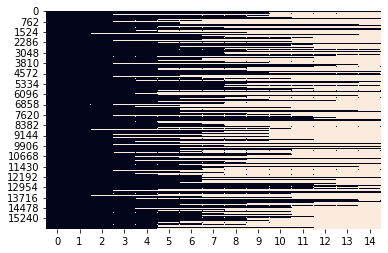

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# Honestly don't know what this is doing, I just followed the website's instructions
# Looks like this shows the padding heat map or something similar to that
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Obtain the Embedding Matrix, which is necessary for the machine learning algorithm.

In [ ]:
embeddings = np.zeros((len(dic_vocabulary)+1, 25))
counter=0
for word, idx in dic_vocabulary.items():
    # embeddings[idx] = word_embed[word]
    try:
        # Reminder: word_embed is the pre-trained word embedding model...
        embeddings[idx] = word_embed[word]
    except:
        counter += 1
        pass

print(f"Number of words in dictionary that have been assigned a matrix of 0's: {counter}")

# word = "data"
# print("dic[word]:", dic_vocabulary[word], "|idx")
# print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
#       "|vector")

Number of words in dictionary that have been assigned a matrix of 0's: 872


#### Neural Network

Referencing source: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
from keras.models import Sequential
from keras import layers, models, optimizers
import keras

def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name='attention')(x)
    x = layers.multiply([inputs, x])
    return x

# input
x_in = layers.Input(shape=(maxlen,))

# embedding
# trainable=False means that these embedding weights will not change. What if they did though?
x = layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=maxlen, trainable=False)(x_in)

# apply attention
x = attention_layer(x, neurons=maxlen)

# 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2))(x)

# final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 25)       336975      ['input_2[0][0]']                
                                                                                                  
 permute_1 (Permute)            (None, 25, 15)       0           ['embedding_1[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 25, 15)       240         ['permute_1[0][0]']              
                                                                                            

In [ ]:
# The fitting method should be placed in a variable so that results can be easily extracted later...
# For now, I would like to see training happening in real time, so making it verbose I guess.
# Still need to adjust hyper-parameters for better results... if I can get better results.
# batch_size=256 (default given on the website)
model.fit(x=X_train, y=data_train['emotion_enc'], batch_size=32, epochs=100,
                     shuffle=True, verbose=1, validation_data=[X_val, data_val['emotion_enc']])

Epoch 1/100
500/500 [==============================] - 17s 22ms/step - loss: 1.3113 - accuracy: 0.4904 - val_loss: 1.2560 - val_accuracy: 0.5145
Epoch 2/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2876 - accuracy: 0.5002 - val_loss: 1.2340 - val_accuracy: 0.5170
Epoch 3/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2695 - accuracy: 0.5077 - val_loss: 1.2225 - val_accuracy: 0.5305
Epoch 4/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2576 - accuracy: 0.5079 - val_loss: 1.2134 - val_accuracy: 0.5335
Epoch 5/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2505 - accuracy: 0.5097 - val_loss: 1.1854 - val_accuracy: 0.5340
Epoch 6/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2264 - accuracy: 0.5161 - val_loss: 1.1614 - val_accuracy: 0.5370
Epoch 7/100
500/500 [==============================] - 11s 22ms/step - loss: 1.2227 - accuracy: 0.5226 - val_loss: 1.1483 - val_ac

#### [IGNORE] ~Using GloVe (Pre-trained Word Embeddings)~

In [ ]:
# IGNORE this code block for now.
# import numpy as np

# def create_embedding_matrix(model, word_index, embedding_dim):
#     counter=0
#     vocab_size = len(word_index) + 1
#     embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
    
#     for word in word_index:
#         idx = word_index[word]
#         try:
#             tmp_vec = model[word]
#         except:
#             tmp_vec = np.zeros(embedding_dim)
#             counter += 1

#         embedding_matrix[idx] = np.array(tmp_vec, dtype=np.float32)[:embedding_dim]
    
#     # with open(filepath) as f:
#     #     for line in f:
#     #         word, *vector = line.split()
#     #         if word in word_index:
#     #             idx = word_index[word]
#     #             embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
#     print(f"Word Index length: {len(word_index)}. Total number of 0's: {counter}")
#     return embedding_matrix

In [ ]:
# word_index['test']
# word_embed['test']
# t1, *test = model['test']
# print(t1)
# print(test)
# print(*test)

In [ ]:
# IGNORE this code block for now.
# embedding_dim = 25
# embedding_matrix = create_embedding_matrix(word_embed, tokenizer.word_index, embedding_dim)

#### **[IGNORE]** Training Neural Network

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
#     # fit the training dataset on the classifier
#     classifier.fit(feature_vector_train, label)
    
#     # predict the labels on validation dataset
#     predictions = classifier.predict(feature_vector_valid)
    
#     if is_neural_net:
#         predictions = predictions.argmax(axis=-1)
    
#     return metrics.accuracy_score(predictions, data_val['label_enc'])

In [ ]:
# # Test CNN (This doesn't work of course lol...)
# from keras.models import Sequential
# from keras import layers, models, optimizers

# # Add an Input Layer
# input_layer = layers.Input((50, ))

# # Add the word embedding Layer
# embedding_layer = layers.Embedding(vocab_size, 25, weights=[embedding_matrix], trainable=False)(input_layer)
# embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

# # Add the convolutional Layer
# conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

# # Add the pooling Layer
# pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

# # Add the output Layers
# output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
# output_layer1 = layers.Dropout(0.25)(output_layer1)
# output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

# # Compile the model
# model = models.Model(inputs=input_layer, outputs=output_layer2)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# accuracy = train_model(model, X_train, data_train['label_enc'], X_val, is_neural_net=True)
# print("CNN, Word Embeddings", accuracy)

# history = model.fit(X_train, data_train['label_enc'],
#                     epochs=10,
#                     validation_data=(X_test, data_test['label_enc']),
#                     batch_size=10)



# embedding_dim = 50
# model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(X_train, data_train['label_enc'],
#                     epochs=10,
#                     validation_data=(X_test, data_test['label_enc']),
#                     batch_size=10)

#### **[IGNORE]** Ignore commented code (below) for the rest of this section.

In [ ]:
# Testing n-grams stuff here.
# import nltk
# from nltk.util import ngrams
# from collections import Counter

# corpus = data_train["sentence"]
# for string in corpus:
#     token = nltk.word_tokenize(string)
#     bigrams = ngrams(token,2)
#     trigrams = ngrams(token,3)
# print(Counter(trigrams))

In [ ]:
# Train our own word embedding model based on our own data set.
# corpus = data_train["sentence"]

# Create list of lists of unigrams
# lst_corpus = []
# for string in corpus:
#     lst_words = string.split()
#     lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
#     lst_corpus.append(lst_grams)


# Detect bigrams and trigrams
# bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
# bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

# trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

# nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=25, window=8, min_count=1, sg=1, epochs=30)
# word = "data"
# nlp[word].shape

In [ ]:
# Testing code from StackOverflow
# https://stackoverflow.com/questions/46129335/get-bigrams-and-trigrams-in-word2vec-gensim
# documents = ["the mayor of new york was there", "machine learning can be useful sometimes","new york mayor was present"]

# sentence_stream = [doc.split(" ") for doc in documents]
# print(sentence_stream)

# bigram = gensim.models.phrases.Phrases(sentence_stream, min_count=1, threshold=2, delimiter=b' ')

# bigram_phraser = gensim.models.phrases.Phraser(bigram)


# print(bigram_phraser)

# for sent in sentence_stream:
#     tokens_ = bigram_phraser[sent]

#     print(tokens_)

In [ ]:
# Testing: Gets the index of where the embedded model
# model.vocab["whatever"].index
# Now use the source above, section 2.3 and follow instructions there.
# (And write it in the section below)

## IGNORE THINGS IN THIS SECTION.

**Ignore code blocks below this one please.**

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

# # Filter out stopwords
# stop_words = set(stopwords.words('english'))

# words = [word for word in words if not word in stop_words]

In [ ]:
# from keras_preprocessing.text import Tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(data_train, axis=0))

In [ ]:
# vocabSize = 15000

Padding will require the text to be already in numbers... so I can't run this yet.

In [ ]:
# from nltk.stem.porter import PorterStemmer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import re

# def text_cleaning(df, column):
#   stemmer = PorterStemmer()
#   corpus = []

#   for text in df[column]:
#     text = re.sub("[^a-zA-Z]", " ", text)
#     text = text.lower()
#     text = text.split()
#     text = [stemmer.stem(word) for word in text if word not in stop_words]
#     text = " ".join(text)
#     corpus.append(text)
  
#   # pad = pad_sequences(sequences=corpus, maxlen=max_len, padding='pre')
#   # return pad
#   return corpus

In [ ]:
# data_train_clean = text_cleaning(data_train, 'sentence')
# data_test_clean = text_cleaning(data_test, 'sentence')
# data_val_clean = text_cleaning(data_val, 'sentence')

### Pre-Processing: Method 1

Source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble

# import pandas, xgboost, numpy, textblob, string
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

# train_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_train['sentence']), maxlen=300)
# test_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_test['sentence']), maxlen=300)
# valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_val['sentence']), maxlen=300)

In [ ]:
# Create list of strings into a single long string for processing
# title_list = [title for title in data_train['sentence']]

# We definitely are not doing this.
# Collapse the list of strings into a single long string for processing
# big_title_string = ' '.join(title_list)

In [ ]:
# from nltk.tokenize import word_tokenize
# Tokenize the string into words
# tokens = word_tokenize(big_title_string)

# Filter out stopwords
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

# words = [word for word in words if not word in stop_words]

### Pre-Processing: Method 2

Sources:

* https://github.com/adsieg/Multi_Text_Classification/blob/master/%5BIntroduction%5D%20-%20Big%20tutorial%20-%20Text%20Classification.ipynb
* https://www.tensorflow.org/text/guide/word_embeddings
* Only BOW and TF-IDF: https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble

# import pandas, xgboost, numpy, textblob, string
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

In [ ]:
# data_train['length'] = [len(x) for x in token]
# data_train.head()
# max_len = data_train['length'].max()
# print(max_len)

### Word Vectorization

We can use the `gensim` library to train our own word2vec model on a custom corpus either with CBOW or Skip Gram.

word2vec cannot create a vector from a word that is not in its vocabulary. So we need to specify "if word in model.vocab" when creating the full list of word vectors (source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751)

In [ ]:
# Relevant Libraries for Word Vectorization
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble
# from sklearn.preprocessing import LabelEncoder

# !pip install nltk
# !pip install gensim
# import gensim
# from nltk.tokenize import sent_tokenize, word_tokenize
# from gensim.models import Word2Vec